# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.patches as mpatches
from sklearn.metrics import ConfusionMatrixDisplay

# Loading dataset


In [2]:
df = pd.read_csv('data/diabetes_prediction_dataset.csv')

In [3]:
df = pd.read_csv('data/diabetes_prediction_dataset.csv')
df.rename(columns={'diabetes': 'target'}, inplace=True)

In [4]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,target
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# Comparing features and data preprocessing

In [5]:
categorical_columns = ['gender', 'hypertension', 'heart_disease', 'smoking_history', 'diabetes']
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=col, hue='diabetes')
    plt.title(f'Countplot of {col} vs. Diabetes')
    plt.show()

ValueError: Could not interpret value `diabetes` for `hue`. An entry with this name does not appear in `data`.

<Figure size 800x600 with 0 Axes>

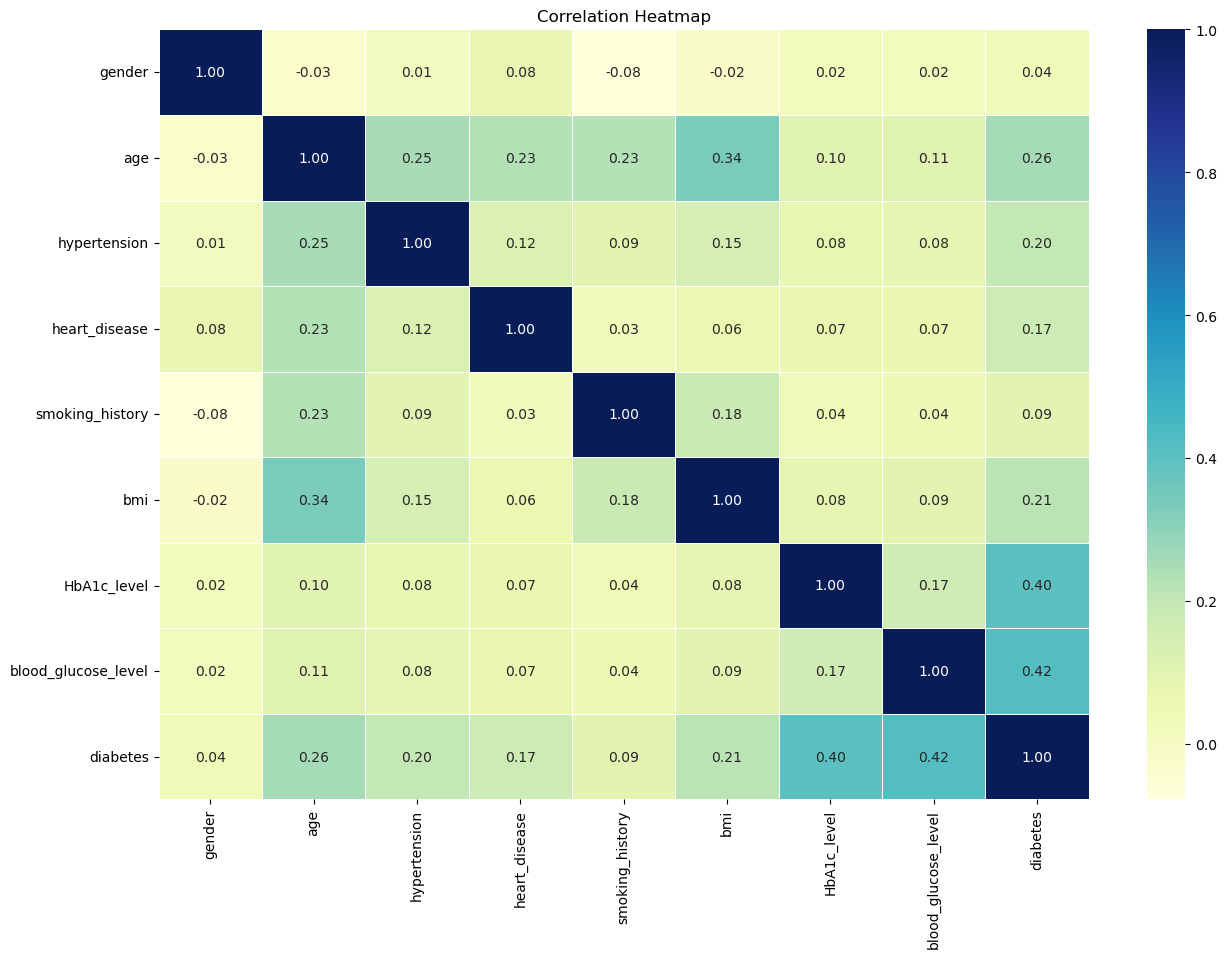

In [22]:
categorical_columns = ['gender', 'smoking_history']  

label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

corr_matrix = df.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()


# Model building


In [10]:
X = df.drop("target", axis=1)
y = df["target"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [25]:
clf_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [26]:
y_pred = clf_rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification report and confusion matrix
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 97.06%
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18292
           1       0.95      0.69      0.80      1708

    accuracy                           0.97     20000
   macro avg       0.96      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000

Confusion Matrix:
[[18232    60]
 [  527  1181]]


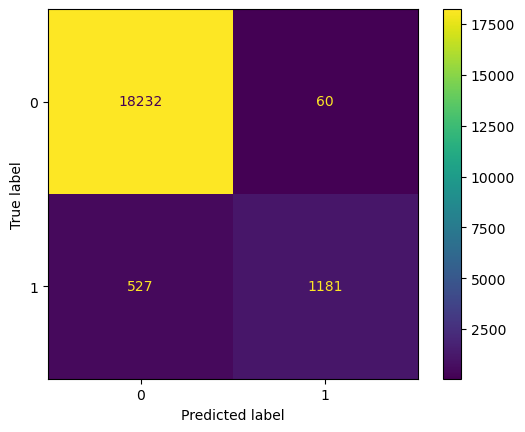

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()